In [1]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [7]:
import pylab as plt
import numpy as np
import torch
import torch.nn as nn
import typing as tp
from torch.nn import functional as F
from fft_conv_pytorch import FFTConv2d

from pyrofit.utils import pad_dims
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import AnalyticSource
from pyrofit.utils.torchutils import unravel_index
from pyrofit.utils import kNN

import swyft
from swyft.lightning.components import (
    RatioEstimatorGaussian1d, MeanStd, SimpleDataset, subsample_posterior,
    get_1d_rect_bounds, append_randomized, valmap, SwyftModel, persist_to_file, 
    equalize_tensors, SwyftTrainer, SampleStore, dictstoremap, DictDataset, SwyftModule, SwyftDataModule, RatioSamples,
    RatioSampleStore
)

## Physics model

In [8]:
NPIX = 50
CHANNELS = [0.5, 1, 2, 4, 8, 16, 32]
SIGMA = 0.02
KNN = 3

In [9]:
class RandomSource:
    def __init__(self, npix =  NPIX, channels = CHANNELS, K = 129):
        self._K = K
        self._channels = channels
        self._npix = npix
        
        self._kernels = self._get_kernels(self._K, self._channels)
        self._conv = self._get_kernel_conv(self._kernels)
        
    @staticmethod
    def _get_kernels(K, channels):
        C = len(channels)
        kernel = np.zeros((C, C, K, K))
        x = np.linspace(-64, 64, K)
        X, Y = np.meshgrid(x, x)
        R = (X**2 + Y**2)**0.5

        for i, s in enumerate(channels):
            kern = np.exp(-0.5*R**2/s**2)
            kern /= (kern**2).sum()**0.5
            kernel[i, i] = kern

        return kernel

    @staticmethod
    def _get_kernel_conv(kernel):
        C = len(kernel)
        K = len(kernel[0][0])
        gaussian_weights = nn.Parameter(torch.tensor(kernel).float().cuda())
        conv = FFTConv2d(in_channels = C, out_channels = C, kernel_size=K, bias=False, padding = int(K/2))
        with torch.no_grad():
            conv.weight = gaussian_weights
        return conv

    def _get_source_image(self, seeds, A=0.5, B = 0.3, C = 0.55, D = 4.):
        scales = A*(np.array(self._channels)/max(self._channels))**B
        seeds = seeds * torch.tensor(scales).cuda().float().unsqueeze(1).unsqueeze(2)
        x = torch.linspace(-1, 1, self._npix).to(seeds.device)
        X, Y = torch.meshgrid([x, x])
        R = (X**2 + Y**2)**0.5
        imgc = self._conv(seeds.unsqueeze(0)).squeeze(0).squeeze(0)
        img = imgc.sum(axis=-3)
        img = torch.exp(img)*(1/(1+(R/C)**D))
        return img

    def __call__(self):
        C = len(self._channels)
        return self._get_source_image(torch.randn(C, self._npix, self._npix).cuda()).detach()

In [10]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return F.grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])

In [11]:
def get_kNN_idx(X, Y, Xsrc, Ysrc, k = 1):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        idx = unravel_index(kNN(P, Psrc, k).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (NPIX, NPIX, k, 2))
        return idx

In [12]:
def deproject_idx(image, kNN_idx):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        k = kNN_idx.shape[-2]
        B = image.shape[0]
        #print(k, B)
        #print(image.shape)
        #print(kNN_idx.shape)
        # TODO: Need to speed up nested python loops
        src_image = torch.stack([torch.stack([image[b, kNN_idx[b, ..., i,0], kNN_idx[b, ..., i,1]] for i in range(k)]) for b in range(B)])
        return src_image

In [23]:
def image_generator(x, y, phi, q, r_ein, slope, src_image):
    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device='cuda')
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 1)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

## Problem-specific analysis components

In [24]:
class Model(SwyftModel):
    def slow(self, pars):
        torch.cuda.set_device(0)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)    
        x, y, phi, q, r_ein, slope = pars['z_lens']
        slope = 2.0
        src_image = pars['src'].cuda()
        img, coords = image_generator(x, y, phi, q, r_ein, slope, src_image)
        X, Y, Xsrc, Ysrc = coords
        kNN_idx = get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
        torch.set_default_tensor_type(torch.FloatTensor)
        return SampleStore(mu = img.cpu(), kNN_idx = kNN_idx.cpu(), X = X.cpu(), Y = Y.cpu(), Xsrc = Xsrc.cpu(), Ysrc = Ysrc.cpu())
    
    def fast(self, d):
        img = d['mu'] + torch.randn_like(d['mu'])*SIGMA
        return SampleStore(img=img)
    
    def prior(self, N, bounds = None):
        src_samples = self.prior_src(N, bounds = bounds)
        lens_samples = self.prior_lens(N, bounds = bounds)
        return SampleStore(**src_samples, **lens_samples)
    
    # Draw from source prior
    def prior_src(self, N, bounds = None):
        rnd_src = RandomSource()
        src = torch.stack([rnd_src().cpu() for _ in range(N)])
        return SampleStore(src=src)

    def prior_lens(self, N, bounds = None):
        if bounds is not None:
            low = bounds['z_lens'].low
            high = bounds['z_lens'].high
        else:
            low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
            high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return SampleStore(z_lens = torch.tensor(draw).float())

In [25]:
m = Model()

## Definition of target image

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-10-b1f3c8208d15>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 1/1 [00:00<00:00, 4760.84it/s]

tensor([0.0635, 0.1425, 0.1874, 0.4622, 1.0166, 2.0884], device='cuda:0')


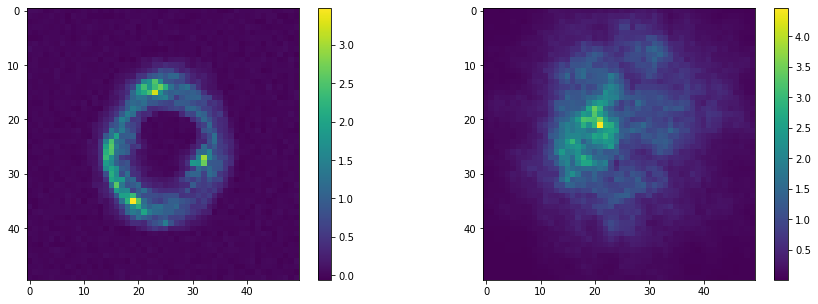

In [26]:
s0 = m.sample(1)[0]
print(s0['z_lens'])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(s0['img'])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(s0['src'])
plt.colorbar()

In [31]:
class LensNetwork(SwyftModule):
    def __init__(self):
        super().__init__()
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(640, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.ptrans = swyft.networks.ParameterTransform(
            6, [(0,), (1,), (2,), (3,), (4,), (5,)], online_z_score=False
        )
        n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        n_observation_features = 16
        self.classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=256,
            dropout_probability = 0.1,
            num_blocks=3,
        )
        
    def forward(self, x, z):
        # Digesting x
        x = dict(img = x['img'])
        x = self.online_z_score(x)['img']
        x = self.CNN(x.unsqueeze(1)).squeeze(1)
        
        # Digesting z
        z = self.ptrans(z['z_lens'])
        
        # Combine!
        x, z = equalize_tensors(x, z)
        ratios = self.classifier(x, z)
        #ratios = ratios.unsqueeze(-1)
        #ratios = torch.cat([ratios, z], dim=-1)
        w = RatioSamples(z.squeeze(-1), ratios)
        return dict(z_lens=w)

In [32]:
class SourceNetwork(SwyftModule):
    def __init__(self):
        super().__init__()
        self.l = torch.nn.Linear(10, 10)
        self.reg1d = RatioEstimatorGaussian1d(momentum = 0.1)
        self.L = torch.nn.Linear(2500, 2500)
        
    def get_img_rec(self, x):
        x_img = x['img']
        x_kNN_idx = x['kNN_idx']
        x_img_rec = deproject_idx(x_img, x_kNN_idx)[:,:,:,:].mean(dim=1)
        x_img_rec = self.L(x_img_rec.view(-1, NPIX*NPIX)).view(-1, NPIX, NPIX)*0 + x_img_rec
        return x_img_rec
    
    def forward(self, x, z):
        x_img_rec = self.get_img_rec(x)
        z_src = z['src']
        x_img_rec, z_src = equalize_tensors(x_img_rec, z_src)
        ratios = self.reg1d(x_img_rec, z_src)
        w = RatioSamples(ratios[...,0], ratios[...,1])
        return dict(z_src = w)

# Workflow

In [33]:
Ntrain1, R1, ME = 3000, 2, 1
tag = 'v4'

In [34]:
bounds = None
results = []
for i in range(R1):
    # s1: img, lens, src ~ p(img|lens, src)p(lens)p(src)
    s1 = m.simulate(Ntrain1, bounds = bounds)
    
    # r1: p(z_lens|img)/p(z_lens)
    r1 = LensNetwork()
    
    # d1: split img vs z_lens
    # TODO: Specify x_keys = ['img'], z_keys=['z_lens']
    d1 = SwyftDataModule(s1, model = m, batch_size = 16)
    
    # Train r1 with d1
    t1 = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = ME)
    t1.fit(r1, d1)

    # r2: p(src|z_lens, img)/p(src)
    r2 = SourceNetwork()
    
    # d2: split (img, kNN_idx) vs src
    # TODO: Specify x_keys = ['img', 'kNN_idx'], z_keys=['src']
    d2 = SwyftDataModule(s1, model = m, batch_size = 16)
    
    # Train r2 with d2
    t2 = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 3)
    t2.fit(r2, d2)
    
    # p1: z_lens ~ p(z_lens|img_obs)  --  these are weighted samples
    p1 = t1.infer(r1, d1, condition_x = s0)
    
    # d3: img, lens, src ~ p(img|lens, src)p(lens|img_obs)
    s3 = m.simulate(100, bounds = bounds, effective_prior = {'z_lens': p1})
    
    # d3: split (img, kNN) vs (z_lens, src)
    # TODO: Specify x_keys = ['img', 'kNN_idx'], z_keys=['z_lens', 'src']
    d3 = SwyftDataModule(s3, model = m, batch_size = 16)
    
    # ws2: src ~ p(src|img_obs) = \int dlens p(src|lens, img_obs)*p(lens|img_obs)  --  weighted samples
    p2 = t2.infer(r2, d3, condition_x = s0)
    
    # Rectangle Bounds
    all_inference = dict(**p1, **p2)
    bounds = get_1d_rect_bounds(all_inference, th = 1e-6)  # for p(z_lens)
    #results.append(dict(bounds = bounds, t1=t1, t2=t2, d1=d1, ws1=ws1, ws2=ws2))

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-10-b1f3c8208d15>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)
100%|██████████| 50/50 [00:01<00:00, 38.21it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 93.3 K
2 | ptrans         | ParameterTransform           | 0     
3 | classifier     | MarginalClassifier           | 2.4 M 
----------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     T

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | l     | Linear                   | 110   
1 | reg1d | RatioEstimatorGaussian1d | 0     
2 | L     | Linear                   | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.010    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 37.51it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 37.52it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 93.3 K
2 | ptrans         | ParameterTransform           | 0     
3 | classifier     | MarginalClassifier           | 2.4 M 
----------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.038    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | l     | Linear                   | 110   
1 | reg1d | RatioEstimatorGaussian1d | 0     
2 | L     | Linear                   | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.010    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

 71%|███████   | 71/100 [00:01<00:00, 37.64it/s]


KeyboardInterrupt: 